![](figs/se04.png)
# Workshop Instructions
***
- <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> Follow along by typing the code yourself - this helps with learning!
- <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> Code cells marked as "Exercise" are for you to complete
- <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> Look for hints if you get stuck
- <img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> Compare your solution with the provided answers
- <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> Don't worry if you make mistakes - debugging is part of learning!

In [11]:
from pathlib import Path
import sys

helper_utils = Path.cwd() / "utils"
sys.path.append(str(helper_utils))

import utils 
import shutil
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

checker = utils.core.ExerciseChecker("SE04")
quizzer = utils.core.QuizManager("SE04")

# 1. Convolutional Neural Networks (CNNs)
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Convolutional Neural Networks (CNNs) are a specialized type of neural network designed for processing structured grid-like data, such as images, by using mathematical operations called convolutions.

CNNs have revolutionized computer vision tasks and are the foundation of many modern systems for image recognition, object detection, segmentation, and more. Their architecture is inspired by the organization of the visual cortex in animals, where individual neurons respond to stimuli in restricted regions called receptive fields.

## 1.1 Why Standard Neural Networks Struggle with Images
***
Images present unique challenges that make standard fully-connected neural networks inefficient:

| Challenge | Description |
|-----------|-------------|
| **Spatial Relationships** | Standard networks don't account for spatial relationships between pixels |
| **Parameter Explosion** | A 224×224×3 image would require over 150,000 weights per neuron |
| **Translation Invariance** | Objects can appear anywhere in an image but have the same meaning |
| **Feature Hierarchy** | Images contain low-level features (edges, textures) that compose into higher-level features |

CNNs address these challenges through specialized architecture components that we'll explore in this workshop.

## 1.2 Key Components of CNNs
***
The power of CNNs comes from their specialized layers that are designed to effectively process visual data:

| Component | Description | Purpose |
|-----------|-------------|---------|
| **Convolutional Layers** | Apply filters to detect features | Extract meaningful patterns at different levels |
| **Pooling Layers** | Downsample the feature maps | Reduce dimensions and computational load |
| **Activation Functions** | Add non-linearity | Allow networks to learn complex patterns |
| **Fully Connected Layers** | Standard neural network layers | Process high-level features for final output |

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/convolution_hyperparameters.gif" alt="CNN Structure" align="center" style="width: 80%; height: auto; margin: 0 auto;">
    <figcaption>Visualization of convolution operation with different parameters</figcaption>
</figure>

Let's begin by understanding the core operation that gives CNNs their name: convolution.

## 2. The Convolution Operation
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: A convolution in the context of CNNs is a mathematical operation that combines two functions by multiplying them and integrating over their overlapping regions.

In simple terms, convolution involves sliding a small window (called a filter or kernel) over an image and performing an element-wise multiplication between the filter and the pixel values, then summing the results to produce a single output value for each position.

### 2.1 How Convolution Works
***

| Step | Description |
|------|-------------|
| 1 | Position the filter at the top-left corner of the image |
| 2 | Perform element-wise multiplication between the filter and the corresponding image pixels |
| 3 | Sum all the resulting values to get a single output value |
| 4 | Move the filter to the next position (typically one pixel to the right) |
| 5 | Repeat steps 2-4 until the entire image has been covered |

This process creates what's called a feature map, which highlights specific patterns or features in the image that match the filter pattern.

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Note**: In deep learning libraries, what's actually implemented is technically cross-correlation rather than convolution (the filter is not flipped). However, since the filters are learned during training, this distinction doesn't matter in practice.

Let's first load an example image to work with:

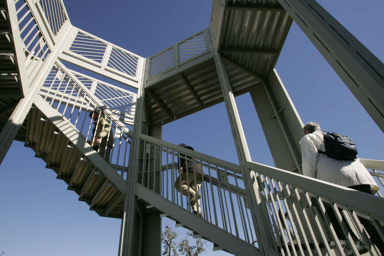

In [12]:
asc_image = Path.cwd() / "figs" / "ascent.jpg"
asc_image = Image.open(asc_image).resize((768//2, 512//2))
asc_image

# 2.2 Key Parameters in Convolution
***
The convolution operation is governed by several key parameters that affect the output dimensions and characteristics of the feature map:

| Parameter | Description | Effect on Output Dimensions |
|-----------|-------------|---------------------------|
| **Kernel Size** | The dimensions of the filter (e.g., 3×3, 5×5) | Larger kernels reduce output size more |
| **Stride** | How many pixels the filter shifts at each step | Larger strides reduce output dimensions |
| **Padding** | Adding extra pixels around the border | Can preserve input dimensions |
| **Dilation** | Spacing between kernel elements | Increases receptive field without increasing parameters |

Understanding how these parameters affect the output dimensions is crucial for designing effective CNN architectures. The formula for calculating the output dimensions of a convolutional layer is:

$$\text{Output Size} = \left\lfloor\frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} + 1\right\rfloor$$

where $\lfloor \cdot \rfloor$ represents the floor operation (rounding down to the nearest integer).

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Note**: This formula assumes that both the input and kernel are square, but it can be applied separately to height and width for rectangular inputs and kernels.

Let's implement a function to calculate the output size of a convolutional layer for various parameter combinations.

In [13]:
# Exercise 1: Calculating Convolutional Output Dimensions 🎯
# Implement a function to calculate the output dimensions after applying convolution
# with different kernel sizes, strides, and padding values.

def calculate_output_size(input_height, input_width, kernel_size, stride=1, padding=0):
    """Calculate the output dimensions after applying convolution.
    
    Args:
        input_height (int): Height of the input feature map
        input_width (int): Width of the input feature map
        kernel_size (int): Size of the square kernel
        stride (int, optional): Convolution stride. Defaults to 1.
        padding (int, optional): Padding size. Defaults to 0.
        
    Returns:
        tuple: (output_height, output_width)
    """
    # Your code here: Implement the formula for calculating output dimensions
    output_height = int((input_height - kernel_size + 2 * padding) / stride + 1)
    output_width = int((input_width - kernel_size + 2 * padding) / stride + 1)
    
    return output_height, output_width

# Test the function with different parameters
# Case 1: Standard convolution with a 3x3 kernel, stride=1, no padding
input1 = (28, 28)  # e.g., MNIST image size
output1 = calculate_output_size(input1[0], input1[1], kernel_size=3)

# Case 2: Convolution with padding=1 to preserve dimensions
input2 = (224, 224)  # e.g., Standard ImageNet size
output2 = calculate_output_size(input2[0], input2[1], kernel_size=3, stride=1, padding=1)

# Case 3: Convolution with stride=2 for downsampling
input3 = (128, 128)
output3 = calculate_output_size(input3[0], input3[1], kernel_size=5, stride=2, padding=2)

# Case 4: Custom parameters
input4 = (64, 64)
output4 = calculate_output_size(input4[0], input4[1], kernel_size=7, stride=2, padding=3)

print(f"Case 1: {input1} → {output1} (3x3 kernel, stride=1, no padding)")
print(f"Case 2: {input2} → {output2} (3x3 kernel, stride=1, padding=1)")
print(f"Case 3: {input3} → {output3} (5x5 kernel, stride=2, padding=2)")
print(f"Case 4: {input4} → {output4} (7x7 kernel, stride=2, padding=3)")

# ✅ Check your answer
answer = {
    'calculate_function': calculate_output_size,
    'output1': output1,
    'output2': output2,
    'output3': output3,
    'output4': output4
}
checker.check_exercise(1, answer)

Case 1: (28, 28) → (26, 26) (3x3 kernel, stride=1, no padding)
Case 2: (224, 224) → (224, 224) (3x3 kernel, stride=1, padding=1)
Case 3: (128, 128) → (64, 64) (5x5 kernel, stride=2, padding=2)
Case 4: (64, 64) → (32, 32) (7x7 kernel, stride=2, padding=3)
--------------------------------------------------------------------------------
❌ Missing conv_operation
💡 Hint: Remember the formula for output size: ((W - K + 2P) / S) + 1
❌ Missing output_size_calculation


## The Convolution Operation
The convolution operation will effectively modify the size of image due to not using any kind of `padding` method. 

> We'll explore padding later on this tutorial, but for now we'll keep things simple.

This method can be used to apply the convolution operation to the images, and visualize the results. It will take the input image and the convolutional filters as arguments, and return the convolved images. We will also add a visualization option to compare the original image with the convolved image.

First, we need to be able to compute the output of the convolved image.

In [ ]:
def compute_convolution_size(img_size: tuple, 
                            kernel_size: int,
                            padding: int = 0,
                            stride: int = 1) -> tuple:
    """
    Compute the output size of an image being transformed
    through the convolution process

    Args:
        img_size (tuple): Size of the input image (height, width)
        kernel_size (int): 
            Size of the filter. It is assumed the kernel is square
        padding (int, optional): Size of convolution padding. Defaults to 0.
        stride (int, optional): Size of stride. Defaults to 1.

    Returns:
        tuple: 
            Output size (height, width) after convolution
    """
    img_height, img_width = img_size
    output_height = int((img_height - kernel_size + 2*padding)/stride + 1)
    output_width = int((img_width - kernel_size + 2*padding)/stride + 1)
    return output_height, output_width

# Example using asc_image dimensions
output_size = compute_convolution_size(asc_image.size, kernel_size=3, padding=1)
print(f"Original size: {asc_image.size[0]}x{asc_image.size[1]}")
print(f"After convolution: {output_size[0]}x{output_size[1]}")


Original size: 384x256
After convolution: 384x256


The convolution function can be implemented by extracting a 3x3 pixel subset to a separate matrix, and then performing an element-wise multiplication between the image subset and the filter. The results are then summed. Let's explore how this works computationally by processing a single 3x3 subset of our image.

In [15]:
# Get a subset sample of our image using
# a 3x3 kernel
kernel_shape = [3,3]
img_subset = np.array(asc_image)[0:kernel_shape[0],0:kernel_shape[1]]
img_subset

array([[[18, 21, 10],
        [19, 22, 11],
        [15, 18,  7]],

       [[19, 23, 12],
        [21, 24, 13],
        [22, 25, 14]],

       [[18, 24, 12],
        [19, 25, 13],
        [18, 24, 12]]], dtype=uint8)

### Filters for Convolutional Layers
Convolutional layers require the user to determine the number of filters (kernels) that should be used. In practice, these filters are a collection of detectors that can detect basic patterns, such as edges and corners, in the early layers of the network. As one goes deeper into the network, more intricate patterns can be recognized, like the patterns that define a human or a horse (depending on the dataset). This capability of the convolutional layers to detect complex patterns from the input data is what makes them so useful and effective in computer vision tasks.

A single filter can be represented as a small, usually rectangular matrix. The dimensions of the matrix must be determined, with 3x3 and 5x5 being good choices for starters. The entries of the filter matrix are initialized with random values that the neural 
network must learn to optimize, based on the dataset provided.

Let's define some common filters to test our convolution method.

> The following filters are well known for image operations, you can explore more of these kernels [here](https://en.wikipedia.org/wiki/Kernel_(image_processing))

In [16]:
sharpen_filter = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur_filter = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

outline_filter = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

Now, we just need to multiply the desired filter to our image subset, and sum the matrix to obtain a new single pixel value

In [17]:
# First the matrix multiplication
filtered = img_subset * sharpen_filter
filtered

array([[[  0, -21,   0],
        [-19, 110, -11],
        [  0, -18,   0]],

       [[  0, -23,   0],
        [-21, 120, -13],
        [  0, -25,   0]],

       [[  0, -24,   0],
        [-19, 125, -13],
        [  0, -24,   0]]])

In [18]:
# Final step is to sum the whole matrix
conv_subset = np.sum(filtered, axis=(1,2)) # We use axis 1 and 2 to sum the rows and columns
print(f"Our convolved subset would produce a single pixel with value {conv_subset}")

Our convolved subset would produce a single pixel with value [41 38 45]


Let's define a function that will take an image and a filter as input, and return the convolved image

In [19]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    """
    Convolve a 2D/3D image with a 2D kernel.

    Args:
         img (np.array): The image to be convolved (grayscale or RGB).
         kernel (np.array): The convolution kernel.
    Returns:
        np.array: Convolved resized image with same number of channels as input
    """
    # Handle RGB (3D) vs grayscale (2D) images
    is_rgb = len(img.shape) == 3
    
    if is_rgb:
        img_height, img_width, channels = img.shape
    else:
        img_height, img_width = img.shape
        channels = 1
        
    kernel_size = kernel.shape[0]
    target_size = compute_convolution_size(
        (img_height, img_width),
        kernel_size=kernel_size
    )
    
    # Initialize output array with appropriate dimensions
    if is_rgb:
        output_array = np.zeros((*target_size, channels))
    else:
        output_array = np.zeros(target_size)
        
    # Process each channel separately for RGB images
    for c in range(channels):
        for ix in range(target_size[0]):
            for jx in range(target_size[1]):
                if is_rgb:
                    img_subset = img[ix:ix+kernel_size, jx:jx+kernel_size, c]
                    output_array[ix, jx, c] = np.sum(np.multiply(img_subset, kernel))
                else:
                    img_subset = img[ix:ix+kernel_size, jx:jx+kernel_size]
                    output_array[ix, jx] = np.sum(np.multiply(img_subset, kernel))
                    
    return output_array

In [20]:
sharpen_asc = convolve(np.array(asc_image), sharpen_filter)
blurred_asc = convolve(np.array(asc_image), blur_filter)
outline_asc = convolve(np.array(asc_image), outline_filter)

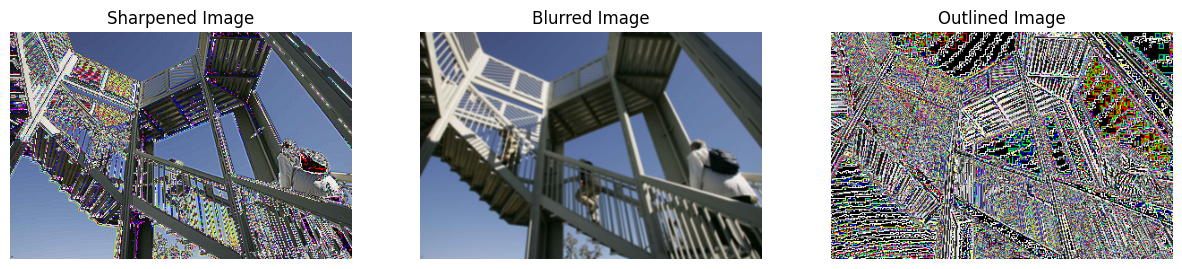

In [21]:
sharp_img = Image.fromarray(sharpen_asc.astype(np.uint8))
blur_img = Image.fromarray(blurred_asc.astype(np.uint8))
outline_img = Image.fromarray(outline_asc.astype(np.uint8))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sharp_img)
axes[0].set_title("Sharpened Image")
axes[0].axis('off')
axes[1].imshow(blur_img)
axes[1].set_title("Blurred Image")
axes[1].axis('off')
axes[2].imshow(outline_img)
axes[2].set_title("Outlined Image")
axes[2].axis('off')
plt.show()

# 3. Filter Design for Feature Extraction
***
Convolutional filters (or kernels) are the heart of CNNs, as they determine what features are extracted from the input image. Different filters can extract different types of features, such as edges, textures, or color patterns.

| Filter Type | Description | Common Applications |
|-------------|-------------|---------------------|
| **Edge Detection** | Highlights boundaries between different regions | Object boundaries, contours |
| **Sharpening** | Enhances fine details by increasing contrast | Image enhancement, detail preservation |
| **Blurring/Smoothing** | Reduces noise or detail | Noise reduction, pre-processing |
| **Embossing** | Creates a 3D relief effect | Texture analysis, artistic effects |

In this exercise, you'll design several common filters used in image processing and computer vision.

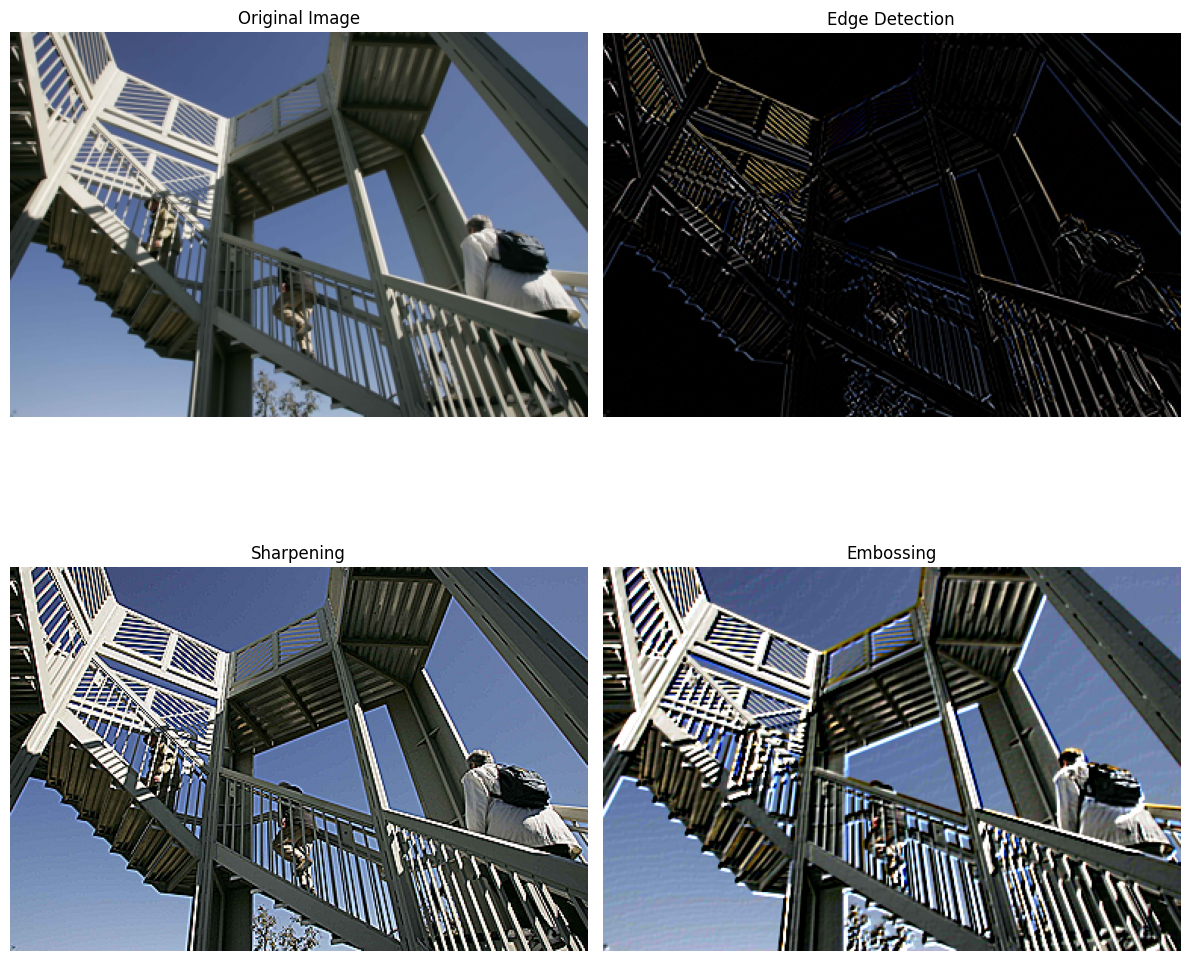

--------------------------------------------------------------------------------
❌ Missing filter_horizontal_edges
💡 Hint: Horizontal edge detection filters should have negative values in the top row and positive in the bottom row
❌ Missing filter_vertical_edges
❌ Missing output_check


In [22]:
# Exercise 2: Designing Convolutional Filters 🎯
# In this exercise, you will implement common filters used in image processing and computer vision

def apply_filter(image, kernel):
    """Apply a convolutional filter to an image.
    
    Args:
        image (numpy.ndarray): Input image (grayscale or RGB)
        kernel (numpy.ndarray): Convolutional kernel/filter
        
    Returns:
        numpy.ndarray: Filtered image
    """
    # Your code here: Use the convolve function we defined earlier
    filtered_image = convolve(image, kernel)
    
    # Clip values to be in valid range for images (0-255)
    filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)
    return filtered_image

# Design several common convolutional filters

# 1. Edge detection filter (should highlight boundaries between different regions)
edge_detection_kernel = np.array([
    [1, 0, -1],
    [0, 0, 0],
    [-1, 0, 1]
])

# 2. Sharpening filter (should enhance details by increasing contrast)
sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

# 3. Embossing filter (should give a 3D effect by highlighting edges with shadows)
emboss_kernel = np.array([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2]
])

# Load a test image - use the ascent image we loaded earlier
test_image = np.array(asc_image)

# Apply the filters to the test image
edge_detect_image = apply_filter(test_image, edge_detection_kernel)
sharpened_image = apply_filter(test_image, sharpen_kernel)
embossed_image = apply_filter(test_image, emboss_kernel)

# Display the results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(test_image)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

axes[0, 1].imshow(edge_detect_image)
axes[0, 1].set_title("Edge Detection")
axes[0, 1].axis('off')

axes[1, 0].imshow(sharpened_image)
axes[1, 0].set_title("Sharpening")
axes[1, 0].axis('off')

axes[1, 1].imshow(embossed_image)
axes[1, 1].set_title("Embossing")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# ✅ Check your answer
answer = {
    'apply_filter': apply_filter,
    'edge_detection_kernel': edge_detection_kernel,
    'sharpen_kernel': sharpen_kernel,
    'emboss_kernel': emboss_kernel
}
checker.check_exercise(2, answer)

## Convolutions in PyTorch
PyTorch provides a built-in function to perform convolutions, which is much more efficient than implementing it manually. The `torch.nn.Conv2d` class is used to create a convolutional layer in PyTorch. It takes several parameters:
- `in_channels`: The number of input channels (e.g., 3 for RGB images).
- `out_channels`: The number of output channels (i.e., the number of filters).
- `kernel_size`: The size of the filter (e.g., 3 for a 3x3 filter).
- `stride`: The step size for moving the filter across the image (default is 1).
- `padding`: The amount of zero-padding added to the input image (default is 0).

The way PyTorch handles images is by using a 4D tensor with the shape `(batch_size, channels, height, width)`. The `Conv2d` layer will take this tensor as input and apply the convolution operation to it. Thus, we need to reshape our image to fit this format.

In [23]:
# Check the shape of the image
np.array(asc_image).shape

(256, 384, 3)

In [24]:
# Change the shape of the image to (C, H, W)
torch_asc = torch.from_numpy(np.array(asc_image)).permute(2,0,1)
torch_asc = torch_asc.unsqueeze(0).float() # Add batch dimension
torch_asc.shape

torch.Size([1, 3, 256, 384])

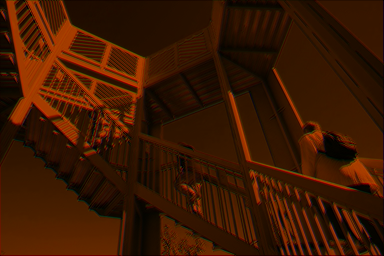

In [25]:
conv2d = torch.nn.Conv2d(
    in_channels=3, 
    out_channels=3, 
    kernel_size=3, 
    stride=1, 
    padding=1, 
)

conv2d.eval()
filtered_asc = conv2d(torch_asc)
# Reverse the transformation to get back to (H, W, C)
filtered_asc = filtered_asc.squeeze(0).detach().numpy().transpose(1, 2, 0)
# Make sure the values are in the range [0, 255]
# and convert to uint8 for PIL
filtered_asc = np.clip(filtered_asc, 0, 255).astype(np.uint8) 
filtered_asc_img = Image.fromarray(filtered_asc)
filtered_asc_img

## Padding and Stride
Padding is the process of adding extra pixels around the border of an image. This is done to control the spatial dimensions of the output feature map. By adding padding, we can ensure that the output size remains the same as the input size, which is useful when we want to maintain the spatial dimensions throughout the network.

Stride is the step size for moving the filter across the image. A stride of 1 means that the filter moves one pixel at a time, while a stride of 2 means that it moves two pixels at a time. Increasing the stride reduces the spatial dimensions of the output feature map, which can be useful for downsampling.

In [27]:
data_path = Path.cwd() / "datasets"
dataset_path = utils.data.download_dataset("historical cracks",
                                   dest_path=data_path,
                                   extract=True,
                                remove_compressed=True)

Downloading:
Historical-crack18-19: A dataset of annotated images for non-invasive surface crack detection in historical buildings
> Authors: Esraa Elhariri, Nashwa El-Bendary, Shereen Taie
> Year: 2020
> Website: https://www.sciencedirect.com/science/article/pii/S2352340922000774#fig0001



Extracting Historical Building Cracks.zip: 100%|██████████| 3899/3899 [00:02<00:00, 1714.17it/s]


In [28]:
main_data_path = list(dataset_path.glob("*"))[0]
images = list(main_data_path.rglob("*.jpg"))

In [29]:
rnd_ix = random.randint(0, len(images) - 1)
img = Image.open(images[rnd_ix])
img.size

(256, 256)

(128, 128)


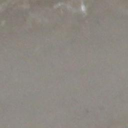

In [30]:
img = img.resize((128, 128))
print(img.size)
img

## The convolution operation

How do convolutions work? This is a common operation in image processing, where a filter is applied to an image to change its underlying characteristics.

Let’s take the pixels in an image as an example. We will analyse each pixel by taking its value and looking at its neighbours. A 3x3 filter can be compared to its immediate neighbour, so a 3x3 grid would be generated. By multiplying each neighbour by the corresponding value in the filter, we get the new value for the pixel.

(100, 100)


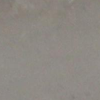

In [31]:
img_ctr_x = img.size[0] // 2
img_ctr_y = img.size[1] // 2

cropped = img.crop((img_ctr_x - 50, img_ctr_y - 50, img_ctr_x + 50, img_ctr_y + 50))
print(cropped.size)
cropped

In [32]:
from torchvision import transforms

ts = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((100, 100)),
    transforms.ToTensor(),
])

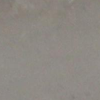

In [33]:
img_tensor = ts(img)
img_tensor.shape

# display the tensor as an image with PIL
img_tensor_pil = transforms.ToPILImage()(img_tensor)
img_tensor_pil

In [34]:
img_crack = main_data_path / "crack"
img_no_crack = main_data_path / "non-crack"

# The no crack images are not balanced with the crack images
# Let's balance them by taking a random sample of the no crack images
crack_images = list(img_crack.glob("*.jpg"))
no_crack_images = list(img_no_crack.glob("*.jpg"))
no_crack_images = random.sample(no_crack_images, len(crack_images))

len(crack_images), len(no_crack_images)


(757, 757)

In [35]:
# Create a new folder for the balanced dataset
balanced_data_path = main_data_path / "balanced"
balanced_data_path.mkdir(parents=True, exist_ok=True)
crack_folder = balanced_data_path / "crack"
crack_folder.mkdir(parents=True, exist_ok=True)
no_crack_folder = balanced_data_path / "no_crack"
no_crack_folder.mkdir(parents=True, exist_ok=True)
# Copy the crack images to the balanced folder
for img in crack_images:
    shutil.copy(img, crack_folder / img.name)
# Copy the no crack images to the balanced folder
for img in no_crack_images:
    shutil.copy(img, no_crack_folder / img.name)


In [36]:
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder

ts = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

data = ImageFolder(balanced_data_path, transform=ts)
targets = data.targets
data.classes

['crack', 'no_crack']

In [37]:
from sklearn.model_selection import train_test_split
train_ix, val_ix = train_test_split(
    torch.arange(len(targets)),
    test_size=0.1,
    shuffle=True,
    random_state=42,
    )
val_ix, test_ix = train_test_split(
    val_ix,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    )

In [38]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_ix)
val_sampler = torch.utils.data.SubsetRandomSampler(val_ix)
test_sampler = torch.utils.data.SubsetRandomSampler(test_ix)

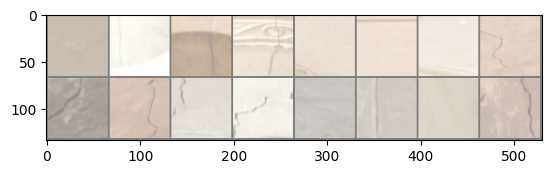

tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0])


In [39]:
# visualize the first image in the dataset
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
loader = DataLoader(data, batch_size=16, sampler=test_sampler,
                    generator=torch.Generator().manual_seed(42))
dataiter = iter(loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(labels)

In [40]:
train_dl = DataLoader(data, batch_size=64, sampler=train_sampler,
                      generator=torch.Generator().manual_seed(42))
val_dl = DataLoader(data, batch_size=64, sampler=val_sampler,
                     generator=torch.Generator().manual_seed(42))
test_dl = DataLoader(data, batch_size=64, sampler=test_sampler,
                      generator=torch.Generator().manual_seed(42))

In [41]:
images[0].max(), images[0].min()

(tensor(0.6549), tensor(0.3490))

In [42]:
class simpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super(simpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,  16, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(16 * 64 * 64, 16)
        self.fc2 = torch.nn.Linear(16, n_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = x.view(-1, 16 * 64 * 64)  # Flatten the tensor
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_v1 = simpleCNN(len(data.classes))
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model_v1.parameters(), lr=5e-3)
num_epochs = 20

simpleCNN Training:   0%|          | 0/20 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch 0/22:   0%|          | 0/22 [00:00<?, ?it/s]

Validation Batch 0/2:   0%|          | 0/2 [00:00<?, ?it/s]

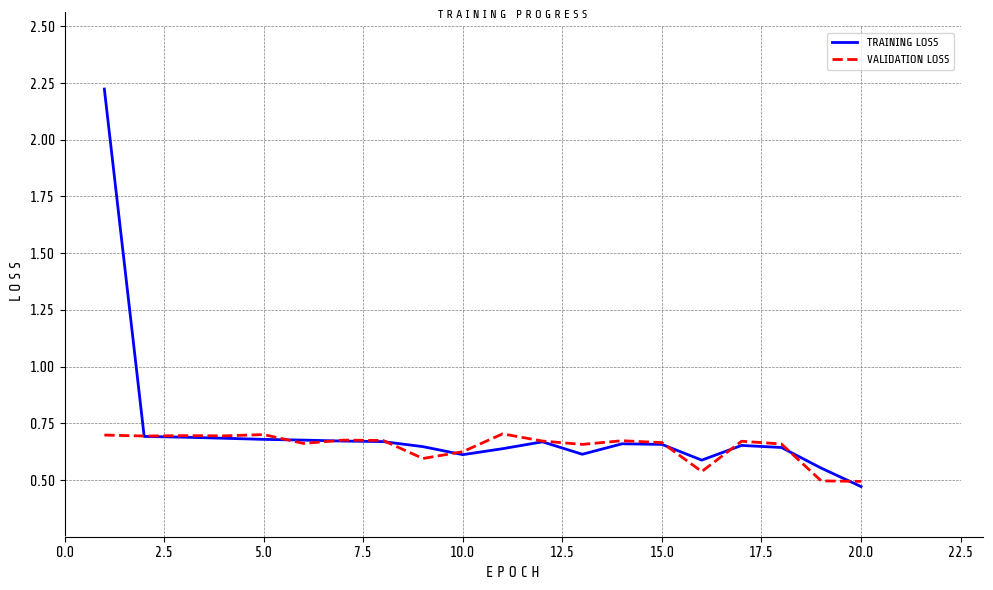

In [44]:
model_v1 = utils.ml.train_model(model_v1,
                             criterion,
                             optimiser,
                             train_loader=train_dl,
                             val_loader=val_dl,
                             num_epochs=num_epochs,
                             plot_loss=True)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v1.eval()
with torch.no_grad():
    for images, labels in test_dl:
        outputs = model_v1(images.to(device))
        print(outputs[:-1])
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        break

tensor([[-0.2767,  0.3734],
        [ 1.6982, -1.1160],
        [ 0.0818,  0.1031],
        [-0.2767,  0.3734],
        [ 0.5319, -0.2364],
        [ 1.5219, -0.9830],
        [-0.2585,  0.3597],
        [-0.2767,  0.3734],
        [-0.2767,  0.3734],
        [ 4.3683, -3.1297],
        [ 0.3307, -0.0847],
        [-0.2767,  0.3734],
        [-0.2767,  0.3734],
        [-0.2767,  0.3734],
        [ 1.2005, -0.7406],
        [-0.2767,  0.3734],
        [ 1.4920, -0.9605],
        [-0.2767,  0.3734],
        [ 1.0855, -0.6539],
        [-0.2767,  0.3734],
        [ 7.9216, -5.8095],
        [-0.2767,  0.3734],
        [-0.2767,  0.3734],
        [-0.2767,  0.3734],
        [ 1.3595, -0.8605],
        [ 0.9403, -0.5444],
        [ 0.1662,  0.0394],
        [ 1.8062, -1.1975],
        [-0.2509,  0.3540],
        [-0.2767,  0.3734],
        [-0.2767,  0.3734],
        [ 1.8589, -1.2372],
        [-0.2767,  0.3734],
        [-0.2767,  0.3734],
        [ 2.9765, -2.0800],
        [-0.2767,  0

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_accuracy(model, test_dataloader):
    model.eval()
    acc = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device).type(torch.long)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            acc += utils.accuracy_score(labels, predicted)

    return acc / len(test_dataloader)



In [47]:
compute_accuracy(model_v1, test_dl)

AttributeError: module 'utils' has no attribute 'accuracy_score'

In [ ]:
from sklearn.metrics import classification_report

test_labels = []
test_preds = []

model_v1.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v1(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
print(classification_report(test_labels, test_preds, target_names=data.classes))

              precision    recall  f1-score   support

       crack       1.00      0.04      0.07        52
    no_crack       0.68      1.00      0.81       104

    accuracy                           0.68       156
   macro avg       0.84      0.52      0.44       156
weighted avg       0.78      0.68      0.56       156



## Regularisation methods
When using convolutional neural networks, we can use regularisation methods to prevent overfitting and to stabilise the training process. The most common regularisation methods are:
- **Dropout**: Randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting.
- **L2 regularisation**: Adds a penalty on the size of the weights to the loss function. This is also known as weight decay.
- **Batch Normalisation**: Normalises the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This helps to stabilise the learning process and can lead to faster convergence.
- **Data augmentation**: Increases the diversity of the training set by applying random transformations to the input data, such as rotation, translation, and scaling. This helps to improve the generalisation of the model.

In [ ]:
class tinyVGG(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(64 * 64 * 64, 128)
        self.fc2 = torch.nn.Linear(128, n_classes)
        # dropout for regularization
        self.dropout1 = torch.nn.Dropout(p=0.05)
        self.dropout2 = torch.nn.Dropout(p=0.1)
        # batch normalization for more stable training
        self.batch_norm1 = torch.nn.BatchNorm2d(16, momentum=0.8)
        self.batch_norm2 = torch.nn.BatchNorm2d(32, momentum=0.8)
        self.batch_norm3 = torch.nn.BatchNorm2d(64, momentum=0.8)

    def forward(self, x):
        x = self.dropout1(torch.nn.functional.relu(self.batch_norm1(self.conv1(x))))
        x = self.dropout1(torch.nn.functional.relu(self.batch_norm2(self.conv2(x))))
        x = self.dropout1(torch.nn.functional.relu(self.batch_norm3(self.conv3(x))))
        x = self.flat(x)
        x = self.dropout2(torch.nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
# torch.cuda.empty_cache()
# model_v2 = regularizedCNN(len(data.classes))
model_v2 = tinyVGG(len(data.classes))
criterion_reg = torch.nn.CrossEntropyLoss()
optimiser_reg = torch.optim.Adam(model_v2.parameters(),
                                 lr=1e-3,
                                 betas=(0.9, 0.999),
                                #  weight_decay=1e-5,  # L2 regularization (weight decay)
                                 ) 
num_epochs_reg = 45
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser_reg,
    mode='min',
    factor=0.1,
    patience=2,
)

tinyVGG Training:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping at epoch 18
Best model saved at c:\Users\Corona\Documents\Git\UoM_fse_dl_workshop\my_models\model_v2.pt


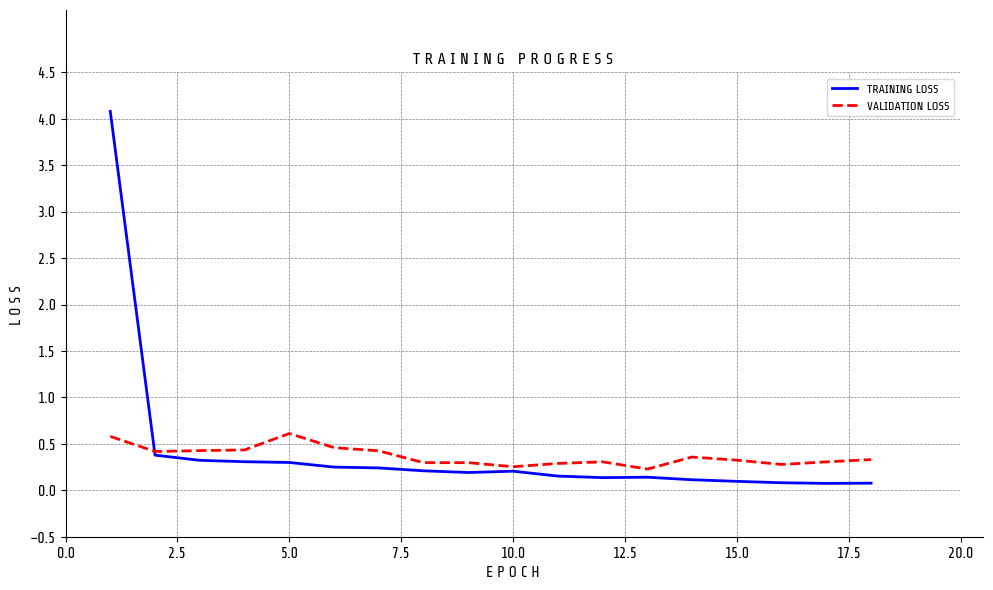

In [ ]:
model_v2 = utils.ml.train_model(model_v2,
                  criterion_reg,
                  optimiser_reg,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs_reg,
                  early_stopping=True,
                  patience=5,
                  tolerance=1e-2,
                  save_path= Path.cwd() / "my_models" / "model_v2.pt",
                  plot_loss=True)

In [ ]:
# Load the best model
model_v2.load_state_dict(torch.load(Path.cwd() / "my_models" / "model_v2.pt"))
compute_accuracy(model_v2, test_dl)

0.9136904761904763

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_labels = []
test_preds = []

model_v2.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v2(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
print(classification_report(test_labels, test_preds, target_names=data.classes))

              precision    recall  f1-score   support

       crack       0.87      0.87      0.87        52
    no_crack       0.93      0.93      0.93       104

    accuracy                           0.91       156
   macro avg       0.90      0.90      0.90       156
weighted avg       0.91      0.91      0.91       156



# 4. Pooling Layers
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Pooling layers reduce the spatial dimensions of feature maps while retaining the most important information, operating independently on each feature channel.

Pooling layers serve several important functions in CNNs:

| Function | Description |
|----------|-------------|
| **Dimension Reduction** | Reduces computational load and memory usage |
| **Translation Invariance** | Makes the network more robust to small shifts in input |
| **Feature Abstraction** | Helps extract dominant features regardless of their exact position |
| **Overfitting Prevention** | Reduces the number of parameters, acting as a form of regularization |

## 4.1 Common Pooling Operations
***

| Type | Description | Advantages | Disadvantages |
|------|-------------|------------|---------------|
| **Max Pooling** | Takes maximum value in pool window | Preserves strong features, faster inference | Loses spatial information |
| **Average Pooling** | Takes average of values in pool window | Preserves background information better | Can dilute strong features |
| **Global Pooling** | Takes maximum/average of entire feature map | Reduces to fixed size regardless of input | Loses all spatial information |

Max pooling is the most commonly used pooling operation in CNN architectures, as it effectively preserves important features while significantly reducing dimensions.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/pooling_visualization.png" alt="Max Pooling" align="center" style="width: 50%; height: auto; margin: 0 auto;">
    <figcaption>Illustration of max pooling with 2x2 filter and stride 2</figcaption>
</figure>

Let's see how pooling affects our feature maps:

In [ ]:
def apply_max_pooling(feature_map, pool_size=2, stride=2):
    """Apply max pooling to a feature map.
    
    Args:
        feature_map (numpy.ndarray): Input feature map
        pool_size (int): Size of the pooling window
        stride (int): Stride of the pooling operation
        
    Returns:
        numpy.ndarray: Pooled feature map
    """
    # Handle RGB (3D) vs grayscale (2D) images
    is_rgb = len(feature_map.shape) == 3
    
    if is_rgb:
        h, w, c = feature_map.shape
        h_out = (h - pool_size) // stride + 1
        w_out = (w - pool_size) // stride + 1
        pooled = np.zeros((h_out, w_out, c))
        
        for i in range(h_out):
            for j in range(w_out):
                for k in range(c):
                    window = feature_map[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size, k]
                    pooled[i, j, k] = np.max(window)
    else:
        h, w = feature_map.shape
        h_out = (h - pool_size) // stride + 1
        w_out = (w - pool_size) // stride + 1
        pooled = np.zeros((h_out, w_out))
        
        for i in range(h_out):
            for j in range(w_out):
                window = feature_map[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size]
                pooled[i, j] = np.max(window)
                
    return pooled

# Apply max pooling to our test image
test_image = np.array(asc_image)
pooled_image = apply_max_pooling(test_image)

# Display the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(test_image)
axes[0].set_title(f"Original Image ({test_image.shape[0]}x{test_image.shape[1]})")
axes[0].axis('off')

axes[1].imshow(pooled_image.astype(np.uint8))
axes[1].set_title(f"After Max Pooling ({pooled_image.shape[0]}x{pooled_image.shape[1]})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4.2 Pooling in PyTorch
***

In PyTorch, we can apply pooling operations using the `nn.MaxPool2d` and `nn.AvgPool2d` classes. Let's see how to use them:

In [ ]:
# Convert image to PyTorch tensor
img_tensor = torch.from_numpy(np.array(asc_image)).permute(2, 0, 1).float().unsqueeze(0)

# Create max pooling layer
max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

# Create average pooling layer
avg_pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)

# Apply pooling
max_pooled = max_pool(img_tensor)
avg_pooled = avg_pool(img_tensor)

# Convert back to numpy for visualization
max_pooled_img = max_pooled.squeeze(0).permute(1, 2, 0).numpy().astype(np.uint8)
avg_pooled_img = avg_pooled.squeeze(0).permute(1, 2, 0).numpy().astype(np.uint8)

# Display the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(np.array(asc_image))
axes[0].set_title(f"Original ({asc_image.size[0]}x{asc_image.size[1]})")
axes[0].axis('off')

axes[1].imshow(max_pooled_img)
axes[1].set_title(f"Max Pooling ({max_pooled_img.shape[0]}x{max_pooled_img.shape[1]})")
axes[1].axis('off')

axes[2].imshow(avg_pooled_img)
axes[2].set_title(f"Average Pooling ({avg_pooled_img.shape[0]}x{avg_pooled_img.shape[1]})")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# 5. CNN Architectures
***

Over the years, researchers have developed many CNN architectures that have pushed the state-of-the-art in computer vision tasks. Understanding these architectures provides insights into effective design patterns and the evolution of deep learning for vision tasks.

| Architecture | Year | Key Innovation | Notable Feature |
|--------------|------|----------------|------------------|
| **LeNet-5** | 1998 | First successful CNN | 7-layer network designed for digit recognition |
| **AlexNet** | 2012 | First deep CNN to win ImageNet | Used ReLU activations and dropout |
| **VGG** | 2014 | Simplicity and depth | Used only 3×3 convolutions with increasing depth |
| **GoogLeNet/Inception** | 2014 | Inception modules | Parallel convolutions of different sizes |
| **ResNet** | 2015 | Residual connections | Skip connections allowed training very deep networks |
| **MobileNet** | 2017 | Depthwise separable convolutions | Optimized for mobile devices |
| **EfficientNet** | 2019 | Compound scaling | Balanced depth, width, and resolution scaling |

In [ ]:
# Quiz 1: CNN Components Quiz
print("🧠 Quiz 1: CNN Components Quiz")
quizzer.run_quiz(1)

# Quiz 2: CNN Architecture Quiz
print("\n🧠 Quiz 2: CNN Architecture Quiz")
quizzer.run_quiz(2)

In [ ]:
# Quiz 3: CNN Training Best Practices
print("\n🧠 Quiz 3: CNN Training Best Practices")
quizzer.run_quiz(3)

# Quiz 4: Pooling Layers in CNNs
print("\n🧠 Quiz 4: Pooling Layers in CNNs")
quizzer.run_quiz(4)

In [ ]:
# Quiz 5: Kernel Size Selection
print("\n🧠 Quiz 5: Kernel Size Selection")
quizzer.run_quiz(5)

# 6. Building a Complete CNN Model
***
Now that we understand the fundamental components of CNNs, let's put everything together to build a complete CNN model for image classification. We'll design a CNN architecture with multiple convolutional layers, pooling layers, and fully connected layers.

## 6.1 CNN Architecture Design
***
When designing a CNN architecture, we need to consider several factors:

| Component | Design Considerations |
|-----------|------------------------|
| **Input Layer** | Depends on the image dimensions and number of channels |
| **Convolutional Layers** | Number, filter size, stride, padding, number of filters |
| **Pooling Layers** | Type of pooling, pool size, stride |
| **Activation Functions** | ReLU is common, but others might perform better for specific tasks |
| **Fully Connected Layers** | Number of layers, number of neurons per layer |
| **Output Layer** | Depends on the task (e.g., classification, regression) |

Let's design a CNN model for our crack detection dataset. This will be a binary classification model that predicts whether an image contains a crack or not.

In [ ]:
# Exercise 3: Building a Simple CNN Model 🎯
# In this exercise, you will implement a simple CNN model for image classification

class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=2):
        """Initialize a simple CNN model for image classification.
        
        Args:
            num_classes (int): Number of output classes
        """
        super().__init__()
        
        # First convolutional block (Conv -> ReLU -> MaxPool)
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block (Conv -> ReLU -> MaxPool)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the size of the flattened features after the convolutional layers
        # For a 64x64 input image, after 2 pooling layers with stride 2, we get 64/(2^2) = 16
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(32 * 16 * 16, 128)
        self.relu3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(128, num_classes)
        
    def forward(self, x):
        """Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, channels, height, width]
            
        Returns:
            torch.Tensor: Output tensor of shape [batch_size, num_classes]
        """
        # First convolutional block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Flatten and fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

# Create an instance of the model
simple_cnn = SimpleCNN(num_classes=2)

# Print the model architecture
print(simple_cnn)

# Test with a random input tensor
batch_size = 32
channels = 3
height = 64
width = 64

# Create a random input tensor
x = torch.randn(batch_size, channels, height, width)

# Forward pass
output = simple_cnn(x)

# Print the output shape
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

# Count the total number of parameters in the model
total_params = sum(p.numel() for p in simple_cnn.parameters())
print(f"Total parameters: {total_params:,}")

# ✅ Check your answer
answer = {
    'simple_cnn': simple_cnn,
    'output_shape_test': output.shape,
    'conv_layer_count': len([m for m in simple_cnn.modules() if isinstance(m, torch.nn.Conv2d)])
}
checker.check_exercise(3, answer)

## 6.2 Data Augmentation for Computer Vision
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Data augmentation is a technique used to artificially expand the size of a training dataset by creating modified versions of the existing data.

Data augmentation is crucial for training robust computer vision models, especially when working with limited datasets. By applying random transformations to the training images, we can teach the model to be invariant to these transformations and generalize better to unseen data.

Common image data augmentation techniques include:

| Technique | Description | Implementation in PyTorch |
|-----------|-------------|---------------------------|
| **Random Rotation** | Rotate the image by a random angle | `transforms.RandomRotation(degrees)` |
| **Random Horizontal Flip** | Flip the image horizontally with some probability | `transforms.RandomHorizontalFlip(p)` |
| **Random Vertical Flip** | Flip the image vertically with some probability | `transforms.RandomVerticalFlip(p)` |
| **Random Crop** | Crop a random portion of the image | `transforms.RandomCrop(size)` |
| **Random Resized Crop** | Crop a random portion and resize to a given size | `transforms.RandomResizedCrop(size)` |
| **Color Jitter** | Randomly change brightness, contrast, saturation | `transforms.ColorJitter(brightness, contrast, saturation, hue)` |
| **Gaussian Blur** | Apply Gaussian blur with random sigma | `transforms.GaussianBlur(kernel_size, sigma)` |
| **Normalization** | Normalize with mean and std of dataset | `transforms.Normalize(mean, std)` |

Let's implement data augmentation for our crack detection dataset:

In [ ]:
# Exercise 4: Data Augmentation 🎯
# In this exercise, you will implement data augmentation techniques for crack detection

from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Define data augmentation transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Create datasets with augmentation
train_dataset = ImageFolder(balanced_data_path, transform=data_transforms['train'])
val_dataset = ImageFolder(balanced_data_path, transform=data_transforms['val'])
test_dataset = ImageFolder(balanced_data_path, transform=data_transforms['test'])

# Create data loaders with the same samplers we defined earlier
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler, 
                         generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_dataset, batch_size=64, sampler=val_sampler,
                       generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_dataset, batch_size=64, sampler=test_sampler,
                        generator=torch.Generator().manual_seed(42))

# Visualize some augmented images
def show_augmented_images(dataloader, num_images=5):
    """Display a batch of augmented images."""
    # Get a batch of training data
    inputs, classes = next(iter(dataloader))
    
    # Convert from the normalized tensor format back to displayable format
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Visualization
    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
    
    for i in range(num_images):
        img = inputs[i].cpu() * std + mean  # Denormalize
        img = img.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC
        img = np.clip(img, 0, 1)  # Clip to [0, 1] range for display
        
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {train_dataset.classes[classes[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show augmented training images
show_augmented_images(train_loader)

# ✅ Check your answer
answer = {
    'data_augmentation': {
        'transforms': list(data_transforms['train'].transforms),
        'check_normalization': any(isinstance(t, transforms.Normalize) for t in data_transforms['train'].transforms)
    },
    'train_val_test_split': {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader
    }
}
checker.check_exercise(4, answer)

## 6.3 Training the CNN Model
***
Now that we have designed our CNN architecture and prepared our dataset with data augmentation, we can train the model. Training a CNN involves the following steps:

1. Initialize the model, loss function, and optimizer
2. Loop through the training dataset for a fixed number of epochs
3. For each batch of data:
   a. Forward pass: compute predictions
   b. Compute loss
   c. Backward pass: compute gradients
   d. Update parameters
4. Evaluate the model on the validation set
5. Adjust hyperparameters if needed (e.g., learning rate)

Let's implement these steps to train our CNN model:

In [ ]:
# Exercise 5: Training a CNN with Regularization 🎯
# In this exercise, you will train a CNN model with proper regularization techniques

class ImprovedCNN(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        
        # First convolutional block with batch normalization
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = torch.nn.Dropout2d(0.1)
        
        # Second convolutional block with batch normalization
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = torch.nn.Dropout2d(0.2)
        
        # Third convolutional block with batch normalization
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = torch.nn.Dropout2d(0.3)
        
        # Fully connected layers with dropout
        self.flatten = torch.nn.Flatten()
        # For 64x64 input, after 3 pooling layers: 64/(2^3) = 8
        self.fc1 = torch.nn.Linear(128 * 8 * 8, 256)
        self.bn4 = torch.nn.BatchNorm1d(256)
        self.relu4 = torch.nn.ReLU()
        self.dropout4 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Fully connected
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

# Create the improved model
model = ImprovedCNN(num_classes=len(data.classes))
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # With L2 regularization

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Train the model with early stopping
model = utils.train_model(
    model,
    criterion,
    optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    early_stopping=True,
    patience=5,
    scheduler=scheduler,
    save_path=Path.cwd() / "my_models" / "improved_cnn.pt",
    plot_loss=True
)

# ✅ Check your answer
answer = {
    'model_training': {
        'optimizer': type(optimizer).__name__,
        'learning_rate': optimizer.param_groups[0]['lr'],
        'scheduler_implemented': scheduler is not None
    },
    'regularization': {
        'batch_norm_layers': len([m for m in model.modules() if isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d))]),
        'dropout_layers': len([m for m in model.modules() if isinstance(m, (torch.nn.Dropout, torch.nn.Dropout2d))]),
        'weight_decay': optimizer.param_groups[0]['weight_decay'] > 0
    }
}
checker.check_exercise(5, answer)

## 6.4 Model Evaluation
***
After training the model, we need to evaluate its performance on the test set to measure how well it generalizes to unseen data. We'll calculate various performance metrics such as accuracy, precision, recall, and F1 score.

Let's evaluate our trained model on the test set:

In [ ]:
# Exercise 6: Model Evaluation and Visualization 🎯
# In this exercise, you will evaluate the model performance and visualize results

# Load the best model weights
model.load_state_dict(torch.load(Path.cwd() / "my_models" / "improved_cnn.pt"))
model.eval()  # Set the model to evaluation mode

# Function to evaluate the model
def evaluate_model(model, dataloader, criterion):
    """Evaluate the model on a dataset and return metrics."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = running_loss / len(dataloader.dataset)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    # Calculate precision, recall, and F1 score
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return {
        'loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'predictions': all_preds,
        'labels': all_labels
    }

# Evaluate on test set
test_metrics = evaluate_model(model, test_loader, criterion)

# Print evaluation results
print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test F1 Score: {test_metrics['f1']:.4f}")

# Visualize confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_metrics['confusion_matrix'], data.classes)

# Visualize some model predictions
def visualize_predictions(model, dataloader, classes, num_images=5):
    """Display model predictions on some test images."""
    model.eval()
    images_so_far = 0
    fig, ax = plt.subplots(1, num_images, figsize=(15, 4))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    return
                
                # Convert from the normalized tensor format back to displayable format
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
                
                img = inputs[j].cpu() * std.cpu() + mean.cpu()
                img = img.permute(1, 2, 0).numpy()
                img = np.clip(img, 0, 1)
                
                ax[images_so_far].imshow(img)
                ax[images_so_far].set_title(f'Pred: {classes[preds[j]]}\nTrue: {classes[labels[j]]}')
                ax[images_so_far].axis('off')
                
                images_so_far += 1
    
    plt.tight_layout()
    plt.show()

# Visualize some test predictions
visualize_predictions(model, test_loader, data.classes)

# ✅ Check your answer
answer = {
    'metrics': {
        'accuracy': test_metrics['accuracy'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'f1': test_metrics['f1']
    },
    'visualization_implemented': True
}
checker.check_exercise(6, answer)

## 6.5 Visualizing Feature Maps
***
A powerful way to understand what a CNN is learning is to visualize the feature maps (activations) at different layers of the network. This helps us see which parts of the image are activating specific filters in the network.

Let's create a function to visualize the feature maps of our trained CNN:

In [ ]:
# Load a single test image
dataiter = iter(test_loader)
images, _ = next(dataiter)
image = images[0:1].to(device)  # Add batch dimension

# Function to hook feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for the convolutional layers
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))

# Forward pass
output = model(image)

# Function to visualize feature maps
def visualize_feature_maps(activation, layer_name, num_features=8):
    """Visualize feature maps from a convolutional layer."""
    # Get feature map for the requested layer
    feature_maps = activation[layer_name].squeeze(0).cpu()
    
    # Determine grid size
    grid_size = int(np.ceil(np.sqrt(num_features)))
    
    # Plot feature maps
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle(f'Feature Maps for {layer_name}', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < num_features and i < feature_maps.size(0):
            # Normalize feature map for visualization
            fmap = feature_maps[i].numpy()
            fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)  # Normalize to [0,1]
            
            ax.imshow(fmap, cmap='viridis')
            ax.set_title(f'Filter {i+1}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Visualize feature maps for each layer
visualize_feature_maps(activation, 'conv1', num_features=16)
visualize_feature_maps(activation, 'conv2', num_features=16)
visualize_feature_maps(activation, 'conv3', num_features=16)

# Display the original image for reference
plt.figure(figsize=(6, 6))
img = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show()

# 7. Summary
***
In this workshop, you've learned about Convolutional Neural Networks (CNNs) and their application to computer vision tasks. Here's a summary of the key concepts covered:

1. **Convolutional Operation**: The core building block of CNNs that applies filters to extract features from images.
2. **Pooling Layers**: Used to downsample feature maps, reducing dimensionality while preserving important information.
3. **CNN Architecture Design**: How to combine convolutional layers, pooling layers, and fully connected layers to create a complete CNN architecture.
4. **Data Augmentation**: Techniques to artificially expand the training dataset and improve model generalization.
5. **Training and Regularization**: Methods to prevent overfitting, such as dropout, batch normalization, and weight decay.
6. **Model Evaluation**: How to assess model performance using metrics like accuracy, precision, recall, and F1 score.
7. **Feature Map Visualization**: Techniques to visualize what the CNN is learning at different layers.

CNNs are powerful tools for a wide range of computer vision tasks, including:

- Image classification
- Object detection
- Semantic segmentation
- Face recognition
- Medical image analysis

As you continue to explore deep learning, experiment with different architectures, hyperparameters, and datasets to develop a deeper understanding of how CNNs work and how to optimize them for specific tasks.

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Further Reading**: For more advanced topics in CNNs, explore transfer learning, which allows you to leverage pre-trained models like ResNet, VGG, or EfficientNet for your specific tasks, often with much better results than training from scratch.